In [1]:
import pickle


In [2]:
# load .pkl file
with open("mario_1_1_expert.pkl", "rb") as f:
    data = pickle.load(f)


Data is a list of dictionaries.

Each dictionary contains dict_keys(['obs', 'action'])

In [3]:
data[0]['obs'].shape

(240, 256, 3)

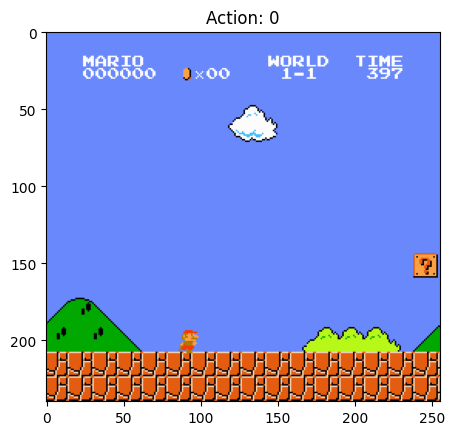

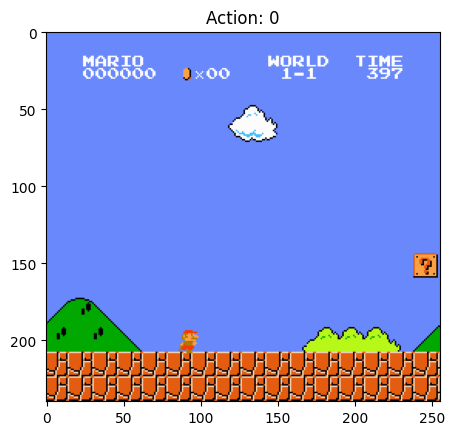

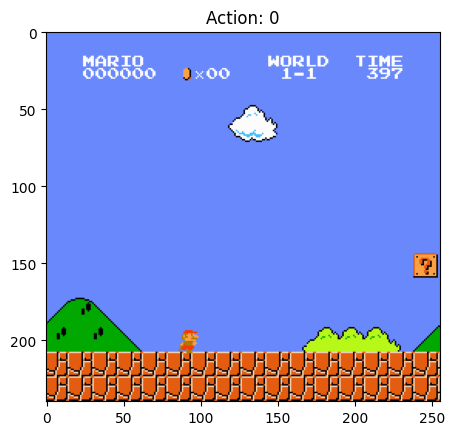

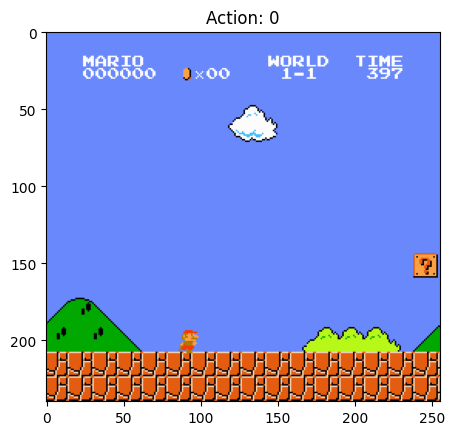

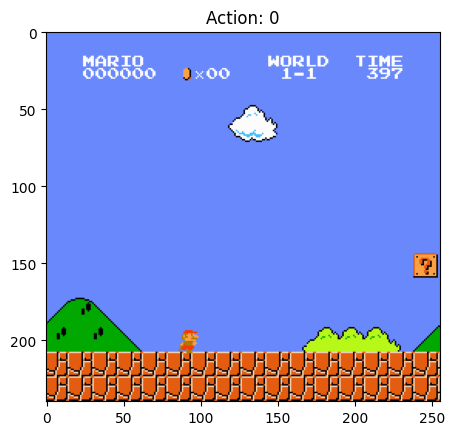

In [4]:
# plot some observations
import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(data[i]['obs'])
    plt.title(f"Action: {data[i]['action']}")
    plt.show()

In [5]:
# Check if observations are actually different
import numpy as np

# Compare first 100 observations
obs_list = [data[i]['obs'] for i in range(min(100, len(data)))]

# Check if all observations are identical
all_same = all(np.array_equal(obs_list[0], obs) for obs in obs_list[1:])
print(f"All observations identical: {all_same}")

# Check diversity: compute pairwise differences
if not all_same:
    # Sample 10 random pairs
    import random
    diffs = []
    for _ in range(10):
        i, j = random.sample(range(len(obs_list)), 2)
        diff = np.abs(obs_list[i].astype(float) - obs_list[j].astype(float)).mean()
        diffs.append(diff)
    print(f"Mean pixel difference between random pairs: {np.mean(diffs):.2f}")
    print(f"If this is very small (<1.0), observations are too similar!")
else:
    print("WARNING: All observations are IDENTICAL!")

All observations identical: True


In [6]:
# Check if preprocessing collapses diversity
import torchvision.transforms as T

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((84, 84)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transform first 10 observations
transformed = [transform(data[i]['obs']).numpy() for i in range(10)]

# Check if transformed observations are too similar
diffs_transformed = []
for i in range(5):
    for j in range(i+1, 10):
        diff = np.abs(transformed[i] - transformed[j]).mean()
        diffs_transformed.append(diff)

print(f"Mean difference after preprocessing: {np.mean(diffs_transformed):.4f}")
print(f"Std of differences: {np.std(diffs_transformed):.4f}")

# Check if all transformed obs have same std
stds = [transformed[i].std() for i in range(10)]
print(f"Std of pixel values per image: {stds}")
print(f"If these are all ~1.0, normalization is working correctly")

Mean difference after preprocessing: 0.0000
Std of differences: 0.0000
Std of pixel values per image: [np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355), np.float32(0.53452355)]
If these are all ~1.0, normalization is working correctly


In [7]:
# Check how many frames and action distribution
print(f"Total frames in dataset: {len(data)}")
print(f"\nAction distribution:")
from collections import Counter
action_counts = Counter([d['action'] for d in data])
for action, count in sorted(action_counts.items()):
    print(f"  Action {action}: {count} ({100*count/len(data):.1f}%)")

# Check if obs array is being reused (memory address issue)
print(f"\nMemory addresses of first 5 observations:")
for i in range(min(5, len(data))):
    print(f"  data[{i}]['obs'] id: {id(data[i]['obs'])}")
    
if len(data) >= 5:
    all_same_id = all(id(data[0]['obs']) == id(data[i]['obs']) for i in range(5))
    if all_same_id:
        print("⚠️  WARNING: All observations share the same memory address!")
        print("   This is a reference bug - you're saving the same array multiple times")

Total frames in dataset: 7800

Action distribution:
  Action 0: 614 (7.9%)
  Action 1: 3908 (50.1%)
  Action 2: 2034 (26.1%)
  Action 3: 101 (1.3%)
  Action 4: 30 (0.4%)
  Action 5: 336 (4.3%)
  Action 6: 777 (10.0%)

Memory addresses of first 5 observations:
  data[0]['obs'] id: 130883552488016
  data[1]['obs'] id: 130883552488016
  data[2]['obs'] id: 130883552488016
  data[3]['obs'] id: 130883552488016
  data[4]['obs'] id: 130883552488016
⚠️  WARNING: All observations share the same memory address!
   This is a reference bug - you're saving the same array multiple times


In [8]:
# Comprehensive diagnostic
print(f"Total frames in dataset: {len(data)}")
print(f"\nAction distribution:")
from collections import Counter
action_counts = Counter([d['action'] for d in data])
for action, count in sorted(action_counts.items()):
    print(f"  Action {action}: {count} ({100*count/len(data):.1f}%)")

# Check memory addresses
print(f"\nMemory addresses of first 10 observations:")
for i in range(min(10, len(data))):
    print(f"  obs[{i}] id: {id(data[i]['obs'])}")

# Critical: Check if it's a reference bug
if len(data) >= 2:
    same_memory = id(data[0]['obs']) == id(data[1]['obs'])
    print(f"\n⚠️  Observations share same memory: {same_memory}")
    
    # Check if arrays are identical in VALUE even if different memory
    arrays_equal = np.array_equal(data[0]['obs'], data[1]['obs'])
    print(f"   Observations equal in VALUE: {arrays_equal}")
    
    if same_memory:
        print("\n🔴 BUG FOUND: Reference bug - same array saved multiple times!")
    elif arrays_equal:
        print("\n🔴 BUG FOUND: Different arrays but identical values - Mario didn't move!")

Total frames in dataset: 7800

Action distribution:
  Action 0: 614 (7.9%)
  Action 1: 3908 (50.1%)
  Action 2: 2034 (26.1%)
  Action 3: 101 (1.3%)
  Action 4: 30 (0.4%)
  Action 5: 336 (4.3%)
  Action 6: 777 (10.0%)

Memory addresses of first 10 observations:
  obs[0] id: 130883552488016
  obs[1] id: 130883552488016
  obs[2] id: 130883552488016
  obs[3] id: 130883552488016
  obs[4] id: 130883552488016
  obs[5] id: 130883552488016
  obs[6] id: 130883552488016
  obs[7] id: 130883552488016
  obs[8] id: 130883552488016
  obs[9] id: 130883552488016

⚠️  Observations share same memory: True
   Observations equal in VALUE: True

🔴 BUG FOUND: Reference bug - same array saved multiple times!


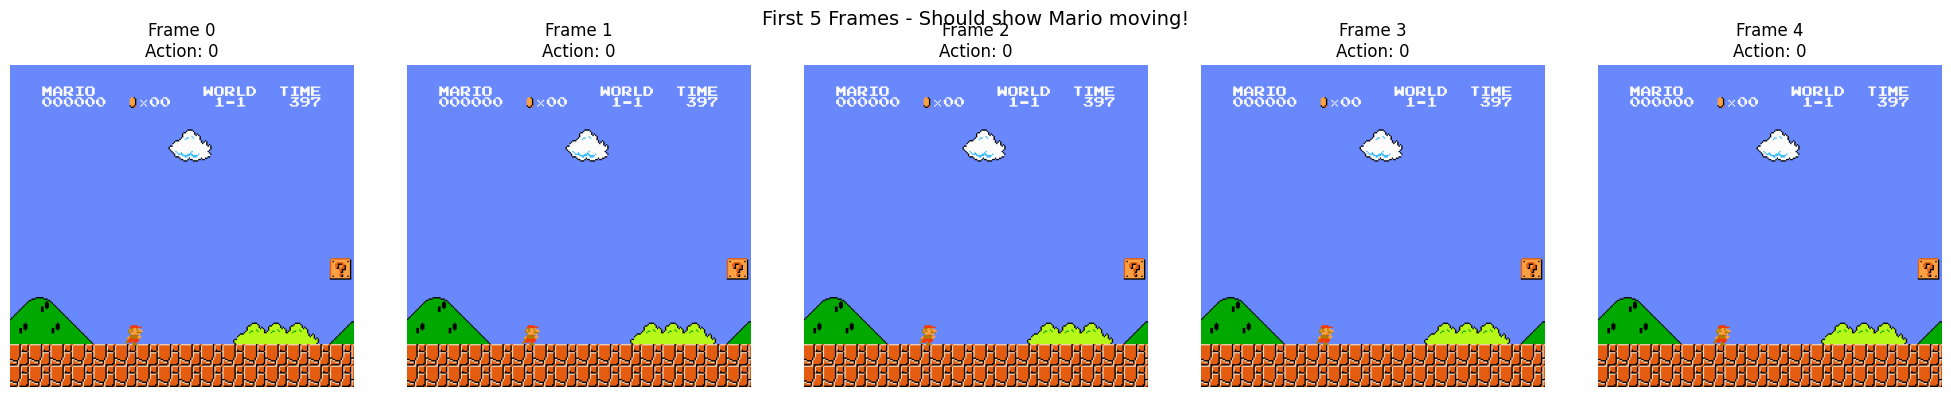


Pixel differences between consecutive frames:
  Frame 0 -> 1: 0.0000 (should be >1.0 if Mario moved)
  Frame 1 -> 2: 0.0000 (should be >1.0 if Mario moved)
  Frame 2 -> 3: 0.0000 (should be >1.0 if Mario moved)
  Frame 3 -> 4: 0.0000 (should be >1.0 if Mario moved)
  Frame 4 -> 5: 0.0000 (should be >1.0 if Mario moved)
  Frame 5 -> 6: 0.0000 (should be >1.0 if Mario moved)
  Frame 6 -> 7: 0.0000 (should be >1.0 if Mario moved)
  Frame 7 -> 8: 0.0000 (should be >1.0 if Mario moved)
  Frame 8 -> 9: 0.0000 (should be >1.0 if Mario moved)
  Frame 9 -> 10: 0.0000 (should be >1.0 if Mario moved)


In [9]:
# Visual check - plot first 5 frames side by side
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(min(5, len(data))):
    axes[i].imshow(data[i]['obs'])
    axes[i].set_title(f"Frame {i}\nAction: {data[i]['action']}")
    axes[i].axis('off')
plt.suptitle("First 5 Frames - Should show Mario moving!", fontsize=14)
plt.tight_layout()
plt.show()

# Check pixel differences between consecutive frames
print("\nPixel differences between consecutive frames:")
for i in range(min(10, len(data)-1)):
    diff = np.abs(data[i]['obs'].astype(float) - data[i+1]['obs'].astype(float)).mean()
    print(f"  Frame {i} -> {i+1}: {diff:.4f} (should be >1.0 if Mario moved)")

In [10]:
# Test if environment stepping works correctly now
print("Testing if Mario environment steps correctly...")
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

obs1 = env.reset()
print(f"Initial obs shape: {obs1.shape}")

# Take action 1 (move right) for 10 steps
obs_list = [obs1]
for i in range(10):
    obs_next, _, _, _ = env.step(1)  # Action 1 = move right
    obs_list.append(obs_next)

env.close()

# Check if observations changed
print(f"\nChecking if observations change when stepping:")
for i in range(min(5, len(obs_list)-1)):
    diff = np.abs(obs_list[i].astype(float) - obs_list[i+1].astype(float)).mean()
    same = np.array_equal(obs_list[i], obs_list[i+1])
    print(f"  Step {i} -> {i+1}: diff={diff:.2f}, identical={same}")

if all(np.array_equal(obs_list[0], obs) for obs in obs_list):
    print("\n⚠️  Environment is BROKEN - observations never change!")
else:
    print("\n✅ Environment works correctly - observations change with steps")

Testing if Mario environment steps correctly...


ModuleNotFoundError: No module named 'gym_super_mario_bros'